In [1]:
# Basic Imports
import pathlib
from pathlib import Path
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
from flax.serialization import (
    to_state_dict, msgpack_serialize, from_bytes
)
import optax

# Logging with Tensorboard or Weights and Biases
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

# For ODESolver
from scipy import integrate

# PyTorch for Dataloaders
import torch
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms

# Wandb 
import wandb
import pprint

# Path to import created files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src")

# Import created functions
import make_dataset as mkds
import visualization as vis
# import NN_model as nnm
import observable_data as od


from numpy.random import default_rng
rng = default_rng(seed=42)

# 0. Create MNIST

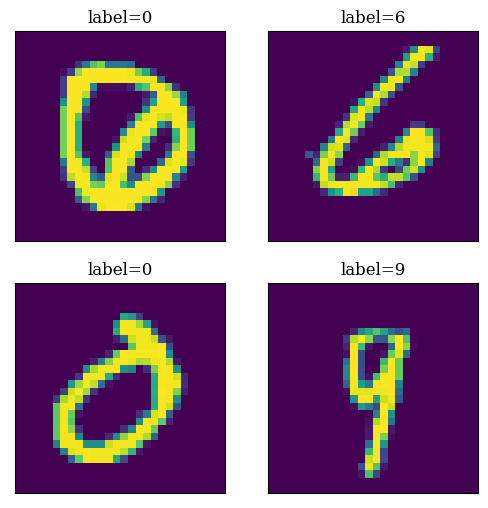

In [2]:
# # Instantiate the data loaders
# train_dl, val_dl, test_dl = mkds.load_data_loaders(batch_size=128)
# # Get a batch of images (batch[0]) and labels (batch[1])
# batch = next(iter(train_dl))
# # Assign the images to a specific variable that we'll use for training
# samples_batch = batch[0]

# # # # Visualize samples of the training dataloader
# vis.plot_MNIST(train_dl, 4)

## 0.1 Creating Cifar-10

In [3]:
# # Instantiate the data loaders
# cifar_trn_dl, cifar_vdl, cifar_tdl = mkds.load_data_loaders(batch_size=128,
#                                                             dataset=CIFAR10, 
#                                                             data_transform=mkds.cifar_transform)

# batch = next(iter(train_dl))

# cifar_imgs = batch[0]
# cifar_lbls = batch[1]

# plt.imshow(cifar_imgs[100])
# print(cifar_lbls[0])

# 1. Perturb the samples

In [4]:
# def visualize_perturbation_progression(batch, sample_idx, rng, tau=0.01, sigma=0.03, M=291):
#     """
#     Function to visualize how Algorithm 2 of the paper effects an MNIST sample.

#     Args:
#     -----
#         batch: np.ndarray   
#             A batch of images of shape (batchsize, n_channels, img_size, img_size)
#         sample_idx: int
#             Index of the specific sample to plot.
#         rng: np.random.generator_.Generator
#             rng used in sampling the hyperparameters in Algorithm 2
#         tau: float
#             Hyperparameter. Not really clear on what it does :)
#         sigma: float
#             Noise parameter. Specifically, it's the standard deviation of the
#             gaussian distribution that is sampled from to get the noise in for
#             the data (y) and the extra dimension (z).
#         M: int
#             Measure of how far out you go from the distribution.

#     Returns:
#     -------
#         A side by side plot of the input image and it's perturbed version
#     """

#     tau = [0, 0.3, 1]
#     M = [0, 100, 300]
#     sigma = [0, 0.03, 1]
#     _, y_tilde, _ = mkds.get_perturbed(batch, rng=rng, tau=tau, sigma=sigma, M=M)
#     perturbed_img = y_tilde[0]

#     fig, ax = plt.subplots(3, 3, figsize=(20,16))
#     ax[0,0].imshow(batch[sample_idx])
#     ax[0,0].set(title='Unperturbed Sample ($\\tau=0$, $\sigma=0$, $M=0$)')
#     ax[0,1].imshow(perturbed_img[sample_idx])
#     ax[0,1].set_title(f'Perturbed Sample ($\\tau=${tau}, $\sigma=${sigma}, $M=${M})')
#     ax[0,2].imshow(perturbed_img[sample_idx])
#     ax[0,2].set_title(f'Perturbed Sample ($\\tau=${tau}, $\sigma=${sigma}, $M=${M})')

#     ax[1,0].imshow(batch[sample_idx])
#     ax[1,0].set(title='Unperturbed Sample ($\\tau=0$, $\sigma=0$, $M=0$)')
#     ax[1,1].imshow(perturbed_img[sample_idx])
#     ax[1,1].set_title(f'Perturbed Sample ($\\tau=${tau}, $\sigma=${sigma}, $M=${M})')
#     ax[1,2].imshow(perturbed_img[sample_idx])
#     ax[1,2].set_title(f'Perturbed Sample ($\\tau=${tau}, $\sigma=${sigma}, $M=${M})')

#     ax[2,0].imshow(batch[sample_idx])
#     ax[2,0].set(title='Unperturbed Sample ($\\tau=0$, $\sigma=0$, $M=0$)')
#     ax[2,1].imshow(perturbed_img[sample_idx])
#     ax[2,1].set_title(f'Perturbed Sample ($\\tau=${tau}, $\sigma=${sigma}, $M=${M})')
#     ax[2,2].imshow(perturbed_img[sample_idx])
#     ax[2,2].set_title(f'Perturbed Sample ($\\tau=${tau}, $\sigma=${sigma}, $M=${M})')
#     plt.show()

In [5]:
# # Create the perturbed data as described in Algorithm 2 of the paper.
# # Note: y_tilde = (y, z) and data = np.concatenate(y, z) 
# #                        ie. data.shape = (batchsize, imgsize**2 + 1)
# x, y_tilde, data = mkds.get_perturbed(samples_batch, rng=rng, M=291)

# # Can visualize how the different hyperparameters visually alter an MNIST sample.
# vis.visualize_single_perturbed(batch=samples_batch, sample_idx=0, rng=rng, tau=0.01, sigma=.03, M=1)
# # Can visualize how the different hyperparameters change how the MNIST samples are lifted into N+1.
# vis.perturb_scatter(samples_batch, rng, M=10)

# 2. Calculate the Poisson/empirical field "labels"

These field coordinates will become the labels we train the NN on.

**Modify `empirical_field` code, so it's clearer how the E fields are being calculated**

In [6]:
# # Create the E field for every batch sample
# y, E = mkds.empirical_field(samples_batch, rng)

# # # Can visualize what the E field in the N+1 dimension would look like
# # # for a specific pixel value (red dot in left plot) 
# # # for the entire batch of data
# vis.visualize_field(batch=samples_batch,
#                 sample_idx=0, 
#                 x_coord=12, 
#                 y_coord=8, 
#                 rng=rng, 
#                 set_lims=False)

## 2.0 Visualization of the empirical Poisson field over a uniform grid of points

Because the empirical field above is sparse in high z/x and very dense at low x/z it's difficult to visualize what exactly the field looks like/if it is what we'd expect. Luckily, it looks smooth, which is a good sign, but to do better we use the functions below. The functions below create a uniform grid of points in the chosen pixel index and calculates what the Poisson field from MNIST would look like on the uniform grid.

In [7]:
# vis.visualize_field_grid(batchsize=400,
#                      sample_idx=0,
#                      x_coord=12,
#                      y_coord=8,
#                      rng=rng,
#                      grid_lims=40)               

# 3. Create datasets to be fed into a NN

- Need to figure out a way to create a new dataloader that gives the perturbed vector & empirical field as (imgs, lbls)
- See if there's a way to do it with the base dataloader or if I need to create a "new" perturbed dataset altogether
- Once I have this train the NN and see how to incorporate wandb sweeps into the training.
- Incorporate sampling into the model 
- For the likelihood estimation, see if I can use the base form of the MLP or if I need to change how the model works ie `model(x)` into `model(x,t)` <- which is what they have in the PFGM code.


In [8]:
# train_dataset = MNIST('saved_data/train',
#                       train=True, 
#                       transform=transforms.Compose([mkds.custom_transform, mkds.empirical_field])
#                       download=False)


In [9]:
# train_data = MNIST('saved_data/train', 
#                    train=True, 
#                    download=False, 
#                    transform=transforms.Compose([mkds.custom_transform, mkds.empirical_field(rng=rng)]))

In [10]:
# train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# batch = next(iter(train_loader))

**Need to change to creating `CustomDataLoader`**

I think I need to create a custom `DataLoader` instead of a custom dataset, because the empirical field needs to be calculated for a `batch` of data instead of for an individual data point because then the empirical field won't be from a sum of fields, but rather just the field from it's unperturbed parent.

In [11]:
# class MNIST_perturb(MNIST):
#     def __init__(self,
#                  root: str,
#                  train: bool = True,
#                  rng: Any, 
#                  **kwargs: Any):
#         """
#         See 
#         https://pytorch.org/vision/stable/_modules/torchvision/datasets/mnist.html#MNIST.__getitem__
#         for what these are, also look at the QMNIST function to see
#         what some of the kwargs are.
#         """
#         # Transforms
#         self.custom_transform = mkds.custom_transform()
#         self.perturb = mkds.empirical_field()

#     def __getitem__(self, index: int):
#         img, label = self.data[index], int(self.target[index])
#         img = self.custom_transform(img)
#         img, label = self.perturb(img, rng)


# # from torch.utils.data import Dataset

# # class MNIST_perturb(Dataset):
# #     def __init__(self, images, labels):
# #         self.images = images
# #         self.labels = labels
# #         self.transforms =  transforms.Compose(
# #             mkds.custom_transform(),
# #             mkds.empirical_field()) # maybe need a () at end of function call)
            
# #     def __getitem__(self, idx):
# #         label = self.labels[idx]
# #         image = self.images[idx]      
# #         image, label = self.transform(np.array(image))
# #         return image, label
# #     def __len__(self):
# #         return len(self.images)

# 4. Train the NN

Good tutorials are the [Flax Basics Notebook](https://colab.research.google.com/github/google/flax/blob/main/docs/guides/flax_basics.ipynb#scrollTo=TUgAbUPpnaJw) and the [Annotated MNIST Notebook](https://colab.research.google.com/github/google/flax/blob/master/docs/getting_started.ipynb#scrollTo=2c40ce90). Also, can checkout the [Optax Docs](https://optax.readthedocs.io/en/latest/) and the [setup vs. @nn.compact page](https://flax.readthedocs.io/en/latest/guides/setup_or_nncompact.html).

In [12]:
# # Instantiate the data loaders
# train_dl, val_dl, test_dl = mkds.load_data_loaders(batch_size=128)
# # Get a batch of images (batch[0]) and labels (batch[1])
# batch = next(iter(train_dl))
# # Assign the images to a specific variable that we'll use for training
# samples_batch = batch[0]

In [13]:
class MLP(nn.Module):
    """
    Simple MLP model for testing PFGM.

    Due to it's simplicity we use @nn.compact instead of setup
    """
    hidden_dims: Sequence[int]
    output_dim: int

    @nn.compact
    def __call__(self, x, **kwargs):
        for dim in self.hidden_dims:
            x = nn.Dense(dim)(x)
            x = nn.silu(x)
        x = nn.Dense(self.output_dim)(x)
        return x

In [14]:
# View model layers
mlp = MLP(hidden_dims=[120, 360],
          output_dim=785)

print(mlp.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 785))))


                                  MLP Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs         ┃ outputs        ┃ params                  ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float32[1,785] │ float32[1,785] │                         │
├─────────┼────────┼────────────────┼────────────────┼─────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,785] │ float32[1,120] │ bias: float32[120]      │
│         │        │                │                │ kernel:                 │
│         │        │                │                │ float32[785,120]        │
│         │        │                │                │                         │
│         │        │                │                │ 94,320 (377.3 KB)       │
├─────────┼────────┼────────────────┼────────────────┼─────────────────────────┤
│ Dense_1 │ Dense  │ float3

In [15]:
# class TrainState(train_state):
#     # A simple extension of TrainState to include batch stats.
#     # If a model has no batch stats, it is None.
#     batch_stats: Any = None
#     # Further extend the TrainState by any additional part here
#     # E.g., rng to keep for init, dropout, etc.
#     rng: Any = None

`TrainState.create()` method has 3 key parameters:
1. `apply_fn`: Typically, the `apply` method of the Flax Module
2. `tx`: Typically, an Optax Optimizer
3. `params`: The parameters from the initialized variable dictionary

In [16]:
def init_train_state(model: Any,
                     random_key: Any,
                     shape: tuple,
                     learning_rate: int) -> train_state.TrainState:
    """
    Function to initialize the TrainState dataclass, which represents
    the entire training state, including step number, parameters, and 
    optimizer state. This is useful because we no longer need to
    initialize the model again and again with new variables, we just 
    update the "state" of the mdoel and pass this as inputs to functions.

    Args:
    -----
        model: nn.Module    
            The model that we want to train.
        random_key: jax.random.PRNGKey()
            Used to trigger the initialization functions, which generate
            the initial set of parameters that the model will use.
        shape: tuple
            Shape of the batch of data that will be input into the model.
            This is used to trigger shape inference, which is where the model
            figures out by itself what the correct size the weights should be
            when they see the inputs.
        learning_rate: int
            How large of a step the optimizer should take.

    Returns:
    --------
        train_state.TrainState:
            A utility class for handling parameter and gradient updates. 
    """
    # Initialize the model
    variables = model.init(random_key, jnp.ones(shape))

    # Create the optimizer
    optimizer = optax.adam(learning_rate) # TODO update this to be user defined

    # Create a state
    return train_state.TrainState.create(apply_fn=model.apply,
                                         tx=optimizer,
                                         params=variables['params'])

state = init_train_state(model=mlp, 
                         random_key=jax.random.PRNGKey(0), 
                         shape=(1, 785), 
                         learning_rate=1e-3)


In [17]:
# # Instantiate the data loaders
# train_dl, val_dl, test_dl = mkds.load_data_loaders(batch_size=128, download=False)
# # Get a batch of images (batch[0]) and labels (batch[1])
# batch = next(iter(train_dl))
# # Assign the images to a specific variable that we'll use for training
# samples_batch = batch[0]

In [18]:
# batch = mkds.empirical_field(samples_batch, rng)
# img, lbl = batch

In [19]:
def compute_metrics(*, pred, labels):
    """
    Function that computes metrics that will be logged
    during training
    """
    # Calculate the MSE loss
    loss = ((pred - labels) ** 2).mean()

    # Calculate the R^2 score
    residual = jnp.sum(jnp.square(labels - pred))
    total = jnp.sum(jnp.square(labels - jnp.mean(labels)))
    r2_score = 1 - (residual / total)

    # Save these metrics into a dict
    metrics = {
        'loss': loss,
        'r2': r2_score
    }

    return metrics

def accumulate_metrics(metrics):
    metrics = jax.device_get(metrics)
    return {
        k: np.mean([metric[k] for metric in metrics])
        for k in metrics[0]
    }

@jax.jit
def train_step(state: train_state.TrainState,
               batch: list):
    """
    Function to run training on one batch of data.
    """
    image, label = batch

    def loss_fn(params):
        pred = state.apply_fn({'params': params}, image)
        loss = ((pred - label) ** 2).mean()
        return loss, pred

    def r_squared(params):
        """
        Function to calculate the coefficient of determination or 
        R^2, which quantifies how well the regression model fits 
        the observed data. Or more formally, it is a statistical
        measure that represents the proportion of variance in the
        dependent variable that is explained by the independent 
        variable(s) in a regression model. R^2 ranges from 0 to 1, 
        with a higher value indicating a better fit. 

        An R^2 of 0 means that the regression model does not explain
        any of the variability in the dependent variable, while an
        R^2 of 1 indicates that the regression model explains all of
        the variability in the dependent model.
        """
        pred = state.apply_fn({'params': params}, image)
        residual = jnp.sum(jnp.square(label - pred))
        total = jnp.sum(jnp.square(label - jnp.mean(label)))
        r2_score = 1 - (residual / total)
        return r2_score

    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, pred), grads = gradient_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(pred=pred, labels=label)
    return state, metrics

@jax.jit
def eval_step(state, batch):
    image, label = batch
    pred = state.apply_fn({'params': state.params}, image)
    return compute_metrics(pred=pred, labels=label)

## TODO
- [ ] Need to make code accumulate the metrics, but also outputs the list of the training at each epoch for visualization purposes 
- [ ] Make this more robust/generalizable for later use
- [ ] Need to include `wandb` logging
- [ ] Need to include checkpointing/loading the models back in once trained
- [ ] Need to save the best model/include code that checks if the model is getting better

**FUTURE WORK:**
- [ ] Make it similar to the Flax version of pytorch lightning thats used in the DL class that I found
- [ ] Mess aroun with the [double descent](https://openai.com/blog/deep-double-descent/) thing shown in lecture

In [22]:
def train_and_evaluate(batchsize, state, epochs, np_rng):
    # # Instantiate the data loaders
    train_dl, val_dl, test_dl = mkds.load_data_loaders(batch_size=batchsize, download=False)
    print("DL created")

    for epoch in tqdm(range(1, epochs+1)):
        best_val_loss = 1e6

        # =========== Training =========== #
        train_batch_metrics = []
        for cnt, batch in enumerate(train_dl):
            print('Inside training loop')
            # Instantiate the imgs
            imgs, _ = batch
            print("Imgs shape = ", imgs.shape)
            # Perturb the data
            perturbed_batch = mkds.empirical_field(imgs, np_rng)
            print("Data perturbed")
            # Do one train step with perturbed data
            state, metrics = train_step(state, perturbed_batch)
            print('Training on a single batch done')
            train_batch_metrics.append(metrics)
            print('Count =', cnt)
        train_batch_metrics = accumulate_metrics(train_batch_metrics)
        # print(
        #     'TRAIN (%d/%d): Loss: $.4f, r2: %.2f' % (
        #         epoch, epochs, train_batch_metrics['loss'], 
        #         train_batch_metrics['r2'])
        # )
        print('end of training')
        # =========== Validation =========== #
        val_batch_metrics = []
        for cnt, batch in enumerate(val_dl):
            # Instantiate the imgs
            imgs, _ = batch
            # Perturb the data
            perturbed_batch = mkds.empirical_field(imgs, np_rng)
            metrics = eval_step(state, perturbed_batch)
            val_batch_metrics.append(metrics)
        val_batch_metrics = accumulate_metrics(val_batch_metrics)
        # print(
        #     'Val (%d/%d): Loss: $.4f, r2: %.2f' % (
        #         epoch, epochs, val_batch_metrics['loss'], 
        #         val_batch_metrics['r2'])
        # )

    return state, train_batch_metrics, val_batch_metrics

state, train_metrics, val_metrics = train_and_evaluate(3, state, 2, rng)

DL created


  0%|          | 0/2 [00:00<?, ?it/s]

Inside training loop
Imgs shape =  (3, 28, 28, 1)
Data perturbed
Training on a single batch done
Count = 0
Inside training loop
Imgs shape =  (3, 28, 28, 1)
Data perturbed
Training on a single batch done
Count = 1
Inside training loop
Imgs shape =  (3, 28, 28, 1)
Data perturbed
Training on a single batch done
Count = 2
Inside training loop
Imgs shape =  (3, 28, 28, 1)
Data perturbed
Training on a single batch done
Count = 3
Inside training loop
Imgs shape =  (3, 28, 28, 1)
Data perturbed
Training on a single batch done
Count = 4
Inside training loop
Imgs shape =  (3, 28, 28, 1)
Data perturbed
Training on a single batch done
Count = 5
Inside training loop
Imgs shape =  (3, 28, 28, 1)
Data perturbed
Training on a single batch done
Count = 6
Inside training loop
Imgs shape =  (3, 28, 28, 1)
Data perturbed
Training on a single batch done
Count = 7
Inside training loop
Imgs shape =  (3, 28, 28, 1)
Data perturbed
Training on a single batch done
Count = 8
Inside training loop
Imgs shape =  (3

In [23]:
train_metrics

{'loss': 1.021364, 'r2': -0.023101272}

DL created


  0%|          | 0/1 [00:00<?, ?it/s]

Inside training loop


# 5. Using Wandb sweep 

In [ ]:
# wandb.login()

# sweep_config = {
#     "method": "grid"
# }

# metric = {
#     "name": "train_loss",
#     "goal": "minimize",
#     "name": "val_loss",
#     "goal": "minimize"
# }

# sweep_config["metric"] = metric

# parameters_dict = {
#     "optimizer": {
#         "values": ["adam", "adamw", "sgd"]
#     },
#     "num_layers": {
#         "values": [10]
#     },
#     "num_features": {
#         "values": [256, 512, 1024]
#     },
#     "epochs": {
#         "values": [2, 4, 8]
#     },
#     "learning_rate": {
#         "values": [1e-4]
#     },
#     "batch_size": {
#         "values": [64, 128]
#     },
# }

# sweep_config["parameters"] = parameters_dict

In [ ]:
# pprint.pprint(sweep_config)

In [ ]:
# def sample_unit_sphere(N_dim, samples, rng):
#     x = rng.standard_normal(size=(samples, N_dim))
#     x /= np.linalg.norm(x, ord=2, axis=-1, keepdims=True)
#     return x

# rng = default_rng()
# u = sample_unit_sphere(2, 100, rng)
# plt.plot(*u.T, '.')